<a href="https://www.kaggle.com/code/rayaldred/predicting-twitter-stocks-using-lstm?scriptVersionId=118410513" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-stocks-dataset/twitter-stocks.csv


# 1. Imports and Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 2. Getting Data

In [3]:
df = pd.read_csv('/kaggle/input/twitter-stocks-dataset/twitter-stocks.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-11-07,45.099998,50.090000,44.000000,44.900002,44.900002,117701670.0
1,2013-11-08,45.930000,46.939999,40.685001,41.650002,41.650002,27925307.0
2,2013-11-11,40.500000,43.000000,39.400002,42.900002,42.900002,16113941.0
3,2013-11-12,43.660000,43.779999,41.830002,41.900002,41.900002,6316755.0
4,2013-11-13,41.029999,42.869999,40.759998,42.599998,42.599998,8688325.0


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2254,2022-10-21,50.000000,50.750000,49.549999,49.889999,49.889999,51209029.0
2255,2022-10-24,50.709999,51.860001,50.520000,51.520000,51.520000,22987553.0
2256,2022-10-25,52.415001,53.180000,52.200001,52.779999,52.779999,35077848.0
2257,2022-10-26,52.950001,53.500000,52.770000,53.349998,53.349998,28064973.0
2258,2022-10-27,53.910000,54.000000,53.700001,53.700001,53.700001,136345128.0


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2259.000000,2259.000000,2259.000000,2259.000000,2259.000000,2.259000e+03
mean,36.020286,36.699881,35.339465,36.003625,36.003625,2.175186e+07
std,14.118463,14.372057,13.828724,14.089989,14.089989,1.909988e+07
min,13.950000,14.220000,13.725000,14.010000,14.010000,0.000000e+00
25%,25.550000,26.215001,24.912501,25.410000,25.410000,1.233530e+07
50%,35.419998,36.099998,34.820000,35.490002,35.490002,1.691305e+07
75%,44.205000,45.015000,43.327501,44.135000,44.135000,2.428082e+07
max,78.360001,80.750000,76.050003,77.629997,77.629997,2.692131e+08


# 3. Visualizations

## Closing Price 

The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

In [6]:
#creating year and month columns
df['Year'] = pd.to_datetime(df['Date']).dt.year


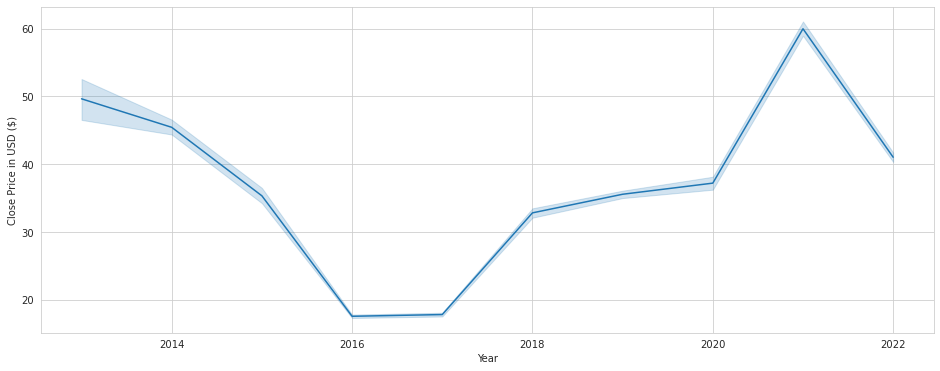

In [7]:
sns.set_style('whitegrid')

plt.figure(figsize=(16,6))
sns.lineplot(data=df, x='Year', y='Close')
plt.ylabel('Close Price in USD ($)')
plt.show()




## Volume of Sales

Volume is counted as the total number of shares that are actually traded (bought and sold) during the trading day or specified set period of time. It is a measure of the total turnover of shares.

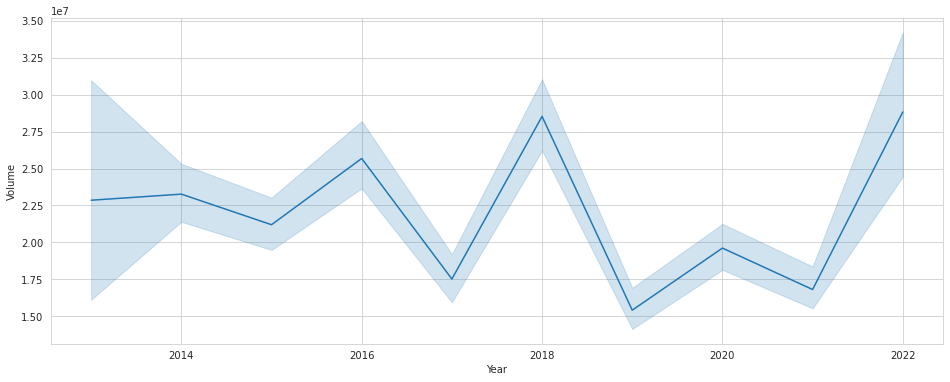

In [8]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df, x='Year', y='Volume')
plt.show()


# 4. Predicting the closing price stock price of Twitter

Thank you to [@faressayah](https://www.kaggle.com/faressayah) for this!

## Preparing the Data 

In [9]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Date', 'Close'])
data = data.set_index('Date')


# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2147

## Scaling the Data

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.48553919],
       [0.43445463],
       [0.45410254],
       ...,
       [0.60939957],
       [0.618359  ],
       [0.62386047]])

## Create the traing data set

In [11]:
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.48553919, 0.43445463, 0.45410254, 0.43838421, 0.44938697,
       0.4822383 , 0.4710783 , 0.42643823, 0.43602643, 0.42502358,
       0.44089912, 0.42423768, 0.39374414, 0.41134865, 0.42266588,
       0.43319713, 0.42077963, 0.43005345, 0.46651997, 0.49685634,
       0.48632509, 0.55218486, 0.59698214, 0.60248352, 0.64948136,
       0.70716759, 0.6696008 , 0.66708587, 0.65231059, 0.68343295,
       0.72304307, 0.79424715, 0.87944045, 0.93209684, 0.78182965,
       0.73090224, 0.78025785, 0.84077338, 0.86435087, 0.82175422,
       0.74583466, 0.71172592, 0.67651683, 0.67573093, 0.68861996,
       0.6947501 , 0.74756369, 0.73184537, 0.75746626, 0.76265327,
       0.76123862, 0.76689722, 0.75023584, 0.69003461, 0.72980197,
       0.71424085, 0.77742853, 0.7936184 , 0.80540714, 0.82222575])]
[0.8167243547653734]

[array([0.48553919, 0.43445463, 0.45410254, 0.43838421, 0.44938697,
       0.4822383 , 0.4710783 , 0.42643823, 0.43602643, 0.42502358,
       0.44089912, 0.42423768, 0.393

## Build the LSTM Model

In [12]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2023-02-06 21:54:51.024778: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-06 21:54:51.675291: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2087/2087 [==============================] - 84s 39ms/step - loss: 0.0022


## Creating the Test Data Set

In [13]:
# Create the testing data set 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

1.8730532056216491

## Plot and Visualize the Data 

I don't know what happened here! I appear to have too many dates in my x, but I don't know how to fix it! Ideally I will only have the years, but have everything else right? Help!

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


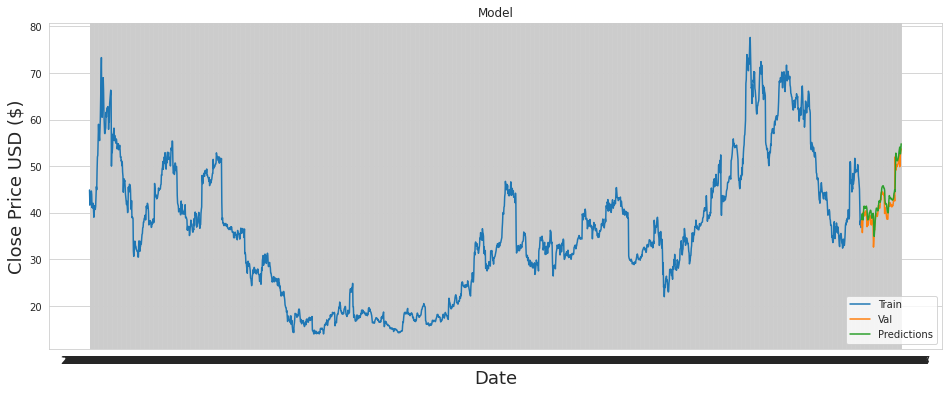

In [14]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


## Show the Valid and Predicted Prices

In [15]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2022-05-19,37.290001,38.555367
2022-05-20,38.290001,38.625023
2022-05-23,37.860001,39.442810
2022-05-24,35.759998,39.832348
2022-05-25,37.160000,38.769192
...,...,...
2022-10-21,49.889999,54.103542
2022-10-24,51.520000,52.787315
2022-10-25,52.779999,52.670921
